# Search for the best model -First iteration 

In this notebook, we're going to try different classification methods in order to select the one to be used at the end.

In [1]:
## Importing data

# Import libraries

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import statsmodels.api
from  sklearn.model_selection  import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
%matplotlib inline

sns.set()

In [2]:
# Reading data
music_df = pd.read_csv("data.csv")

In [3]:
#Characteristics of the data frame
print('Shape : ', music_df.shape)
music_df.head()

Shape :  (1000, 30)


,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [4]:
# Removing the filename column
print("The filename column is not useful for the machine learning algorithm. So we decide to remove it.")
music_df = music_df.drop(["filename"], axis = 1)

The filename column is not useful for the machine learning algorithm. So we decide to remove it.


## Aim of the classification procedure

The goal here is to build a machine learning model that will predict the music genre of a music track given its features. Therefore, we'll divide the dataset between a target value which contains the labels, and the rest will be used as the learning set, called data.

In [5]:
target = music_df.label
data = music_df.drop('label',axis=1)

In [6]:
target.value_counts()

hiphop       100
reggae       100
jazz         100
country      100
classical    100
blues        100
disco        100
pop          100
metal        100
rock         100
Name: label, dtype: int64

The dataset is balanced.

## Preparing the features

### Suppressing the highly correlated features

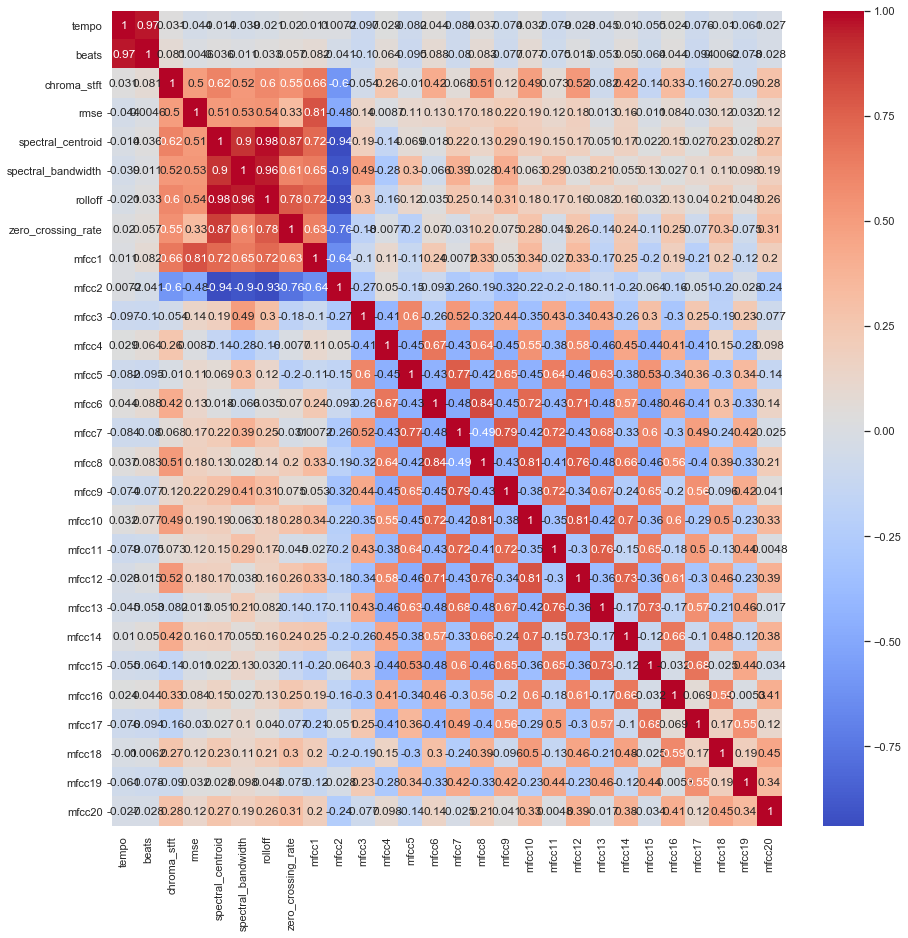

In [7]:
cor = music_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(cor, cmap='coolwarm', annot=True)

The data seems to contain some redundant information. For instance, the features spectral centroid and rolloff are highly correlated. In practice, we are going to suppress the columns whose correlation to another one exceed 0.9.

In [8]:
# Function to remove highly correlated columns

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [9]:
# Removing the columns 

correlation(data, 0.85)
print(data.columns)

Index(['tempo', 'chroma_stft', 'rmse', 'spectral_centroid', 'mfcc1', 'mfcc2',
       'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'mfcc20'],
      dtype='object')


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tempo              1000 non-null   float64
 1   chroma_stft        1000 non-null   float64
 2   rmse               1000 non-null   float64
 3   spectral_centroid  1000 non-null   float64
 4   mfcc1              1000 non-null   float64
 5   mfcc2              1000 non-null   float64
 6   mfcc3              1000 non-null   float64
 7   mfcc4              1000 non-null   float64
 8   mfcc5              1000 non-null   float64
 9   mfcc6              1000 non-null   float64
 10  mfcc7              1000 non-null   float64
 11  mfcc8              1000 non-null   float64
 12  mfcc9              1000 non-null   float64
 13  mfcc10             1000 non-null   float64
 14  mfcc11             1000 non-null   float64
 15  mfcc12             1000 non-null   float64
 16  mfcc13             1000 n

There are no missing values in our data set, so no other treatment is needed.

## Preparing the target column

In [11]:
# Encode the label classes using LabelEncoder
encoder = preprocessing.LabelEncoder()
target = encoder.fit_transform(target)

## Separation between train, validation and test sets

In [12]:
# Split for the train and test datasets
X_train, X_test, y_train, y_test = train_test_split (data, target,
                                                    test_size = 0.2 ,
                                                    random_state = 42 ,
                                                    stratify = target)

In [13]:
# Split for the validation and test datasets
X_test, X_val, y_test, y_val = train_test_split (X_test, y_test,
                                                    test_size = 0.5 ,
                                                    random_state = 42 ,
                                                    stratify = y_test)

In [14]:
# Scale the X data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

# Creation of the clasifier lr  (LogisticRegression)
lr = LogisticRegression(max_iter = 1000, multi_class='auto')

# Parameters on which to train the lr model
parametres_lr = {'C' : [10**i for i in range(-2,5,1)],
                 'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

# Creation of the grid to train the lr model
grid_lr = model_selection.GridSearchCV(lr, param_grid=parametres_lr,cv=5)

In [16]:
# Training of the grid_lr on X_train and y_train
grille = grid_lr.fit(X_train,y_train)

C:\Users\Arthur\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Arthur\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [18]:
# Prediction using lr on X_val
y_pred_lr = grid_lr.predict(X_val)
pd.crosstab(y_val, y_pred_lr, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,7,0,0,0,1,0,1,0,0,1
1,0,9,1,0,0,0,0,0,0,0
2,2,0,5,0,0,0,0,1,1,1
3,1,0,1,6,0,0,0,0,0,2
4,0,0,0,2,6,0,0,1,1,0
5,0,0,2,0,0,8,0,0,0,0
6,0,0,0,0,0,0,10,0,0,0
7,0,0,1,0,2,0,0,7,0,0
8,0,0,0,1,3,0,0,0,5,1


In [19]:
print(classification_report(y_val,y_pred_lr))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       1.00      0.90      0.95        10
           2       0.50      0.50      0.50        10
           3       0.55      0.60      0.57        10
           4       0.46      0.60      0.52        10
           5       0.89      0.80      0.84        10
           6       0.91      1.00      0.95        10
           7       0.78      0.70      0.74        10
           8       0.62      0.50      0.56        10
           9       0.44      0.40      0.42        10

    accuracy                           0.67       100
   macro avg       0.68      0.67      0.67       100
weighted avg       0.68      0.67      0.67       100



As there is a uniform distribution across the ten different classes, we'll base our evaluation of the models mostly on
the accuracy, and on the f1-score.

In [20]:
grid_lr.best_params_

{'C': 10, 'solver': 'liblinear'}

## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
# Creation of the clasifier dt (DecisionTreeClassifier)
dt = DecisionTreeClassifier()
# Fit of dt on (X_train,y_train)
dt.fit(X_train, y_train)
# Prediction using dt on X_val
y_pred_dt = dt.predict(X_val)
pd.crosstab(y_val, y_pred_dt, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,5,0,0,0,0,0,2,0,1,2
1,1,5,2,0,0,2,0,0,0,0
2,1,0,2,0,1,2,0,2,1,1
3,1,0,0,3,1,0,0,0,0,5
4,0,0,0,1,4,0,1,2,2,0
5,2,1,4,1,0,2,0,0,0,0
6,0,0,0,0,2,0,8,0,0,0
7,0,0,0,3,2,0,0,5,0,0
8,0,0,0,0,1,1,1,2,5,0


In [23]:
print(classification_report(y_val,y_pred_dt))

              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.83      0.50      0.62        10
           2       0.25      0.20      0.22        10
           3       0.30      0.30      0.30        10
           4       0.33      0.40      0.36        10
           5       0.29      0.20      0.24        10
           6       0.67      0.80      0.73        10
           7       0.42      0.50      0.45        10
           8       0.50      0.50      0.50        10
           9       0.33      0.40      0.36        10

    accuracy                           0.43       100
   macro avg       0.44      0.43      0.43       100
weighted avg       0.44      0.43      0.43       100



## SVM

In [24]:
from sklearn import svm

# Creation of a SVM classifier
clf = svm.SVC()

# Parameters to test
parametres = {'C' : [0.1,1,10], 'kernel':['rbf', 'linear','poly'],'gamma' : [0.001, 0.1, 0.5]}

# Creation of the grid to test the SVM model
grid_clf = model_selection.GridSearchCV(clf, param_grid=parametres,cv=5)

In [25]:
# Training of the grid_svm on X_train and y_train
grille_svm = grid_clf.fit(X_train,y_train)

In [26]:
# Prediction using grid_clf on X_val
y_pred_svm = grid_clf.predict(X_val)
pd.crosstab(y_val, y_pred_svm, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,6,0,0,0,2,1,1,0,0,0
1,1,7,1,0,0,1,0,0,0,0
2,0,0,8,0,0,0,0,0,0,2
3,0,0,0,7,0,0,0,0,0,3
4,0,0,0,0,9,0,0,0,1,0
5,0,0,2,0,0,7,0,0,1,0
6,1,0,0,0,1,0,8,0,0,0
7,0,0,0,3,0,0,0,7,0,0
8,0,0,0,1,3,0,0,0,6,0


In [27]:
print(classification_report(y_val,y_pred_svm))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       1.00      0.70      0.82        10
           2       0.73      0.80      0.76        10
           3       0.44      0.70      0.54        10
           4       0.60      0.90      0.72        10
           5       0.78      0.70      0.74        10
           6       0.89      0.80      0.84        10
           7       1.00      0.70      0.82        10
           8       0.75      0.60      0.67        10
           9       0.50      0.50      0.50        10

    accuracy                           0.70       100
   macro avg       0.74      0.70      0.71       100
weighted avg       0.74      0.70      0.71       100



In [28]:
grid_clf.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

## KNN

In [29]:
from sklearn import neighbors

# Creation of a KNN classifier
knn = neighbors.KNeighborsClassifier()

# Parameters to test
parametres_knn = {'n_neighbors' : [1,2,5,10,20,50,100], 'metric':['minkowski', 'manhattan']}

# Creation of the grid to test the KNN model
grid_knn = model_selection.GridSearchCV(knn, param_grid=parametres_knn,cv=5)

In [30]:
# Training of the grid_knn on X_train and y_train
grille_knn = grid_knn.fit(X_train,y_train)

In [31]:
# Prediction using grid_knn on X_val
y_pred_knn = grid_knn.predict(X_val)
pd.crosstab(y_val, y_pred_knn, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,7,0,1,0,0,0,2,0,0,0
1,1,9,0,0,0,0,0,0,0,0
2,0,0,8,0,0,1,0,1,0,0
3,1,0,0,7,0,0,0,0,0,2
4,0,0,1,1,5,0,0,1,0,2
5,0,0,1,1,0,6,0,2,0,0
6,1,0,0,0,0,0,8,0,0,1
7,0,0,0,3,0,0,0,7,0,0
8,0,0,0,1,3,0,0,0,6,0


In [32]:
print(classification_report(y_val,y_pred_knn))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       1.00      0.90      0.95        10
           2       0.67      0.80      0.73        10
           3       0.44      0.70      0.54        10
           4       0.62      0.50      0.56        10
           5       0.86      0.60      0.71        10
           6       0.80      0.80      0.80        10
           7       0.64      0.70      0.67        10
           8       1.00      0.60      0.75        10
           9       0.55      0.60      0.57        10

    accuracy                           0.69       100
   macro avg       0.73      0.69      0.70       100
weighted avg       0.73      0.69      0.70       100



In [33]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 5}

## Random Forest

In [34]:
from sklearn import ensemble

# Creation of a RF classifier
RF = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)

# Parameters to test
parametres_RF = {'n_estimators' : [10,20,100,200,500], 'criterion':['gini', 'entropy']}

# Creation of the grid to test the KNN model
grid_RF = model_selection.GridSearchCV(RF, param_grid=parametres_RF,cv=5)

In [35]:
# Training of the grid_RF on X_train and y_train
grille_RF = grid_RF.fit(X_train,y_train)

In [36]:
# Prediction using grid_RF on X_val
y_pred_RF = grid_RF.predict(X_val)
pd.crosstab(y_val, y_pred_RF, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,4,0,0,2,0,1,2,0,1,0
1,0,8,2,0,0,0,0,0,0,0
2,0,0,6,0,0,2,0,1,1,0
3,0,0,0,7,1,0,1,0,0,1
4,0,0,0,1,6,0,0,2,1,0
5,0,0,2,1,0,7,0,0,0,0
6,0,0,0,0,1,0,9,0,0,0
7,0,0,1,1,0,0,0,8,0,0
8,0,0,0,1,3,0,0,0,6,0


In [37]:
print(classification_report(y_val,y_pred_RF))

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       1.00      0.80      0.89        10
           2       0.55      0.60      0.57        10
           3       0.41      0.70      0.52        10
           4       0.55      0.60      0.57        10
           5       0.70      0.70      0.70        10
           6       0.75      0.90      0.82        10
           7       0.62      0.80      0.70        10
           8       0.67      0.60      0.63        10
           9       0.75      0.30      0.43        10

    accuracy                           0.64       100
   macro avg       0.68      0.64      0.64       100
weighted avg       0.68      0.64      0.64       100



In [38]:
grid_RF.best_params_

{'criterion': 'gini', 'n_estimators': 500}

## Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB
# Creation of the clasifier gnb (GaussianNaivesBayes)
gnb = GaussianNB()
# Fit of gnb on (X_train,y_train)
gnb.fit(X_train, y_train)
# Prediction using gnb on X_val
y_pred_gnb = gnb.predict(X_val)
pd.crosstab(y_val, y_pred_gnb, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,4,0,0,0,0,1,4,0,0,1
1,0,8,2,0,0,0,0,0,0,0
2,1,0,5,0,0,1,0,1,0,2
3,0,0,1,2,0,0,3,3,0,1
4,0,0,0,0,2,0,2,5,1,0
5,1,1,1,0,0,4,0,3,0,0
6,0,0,0,0,1,0,9,0,0,0
7,0,0,0,0,0,0,0,10,0,0
8,0,0,0,0,1,0,0,3,5,1


In [40]:
print(classification_report(y_val,y_pred_gnb))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.89      0.80      0.84        10
           2       0.56      0.50      0.53        10
           3       1.00      0.20      0.33        10
           4       0.50      0.20      0.29        10
           5       0.67      0.40      0.50        10
           6       0.45      0.90      0.60        10
           7       0.32      1.00      0.49        10
           8       0.83      0.50      0.62        10
           9       0.29      0.20      0.24        10

    accuracy                           0.51       100
   macro avg       0.62      0.51      0.49       100
weighted avg       0.62      0.51      0.49       100



## Stochastic Gradient Descent

In [41]:
from sklearn.linear_model import SGDClassifier
# Creation of the clasifier sgdc (StohasticGradientDescentClassifier)
sgdc = SGDClassifier()
# Fit of sgdc on (X_train,y_train)
sgdc.fit(X_train, y_train)
# Prediction using sgdc on X_val
y_pred_sgdc = sgdc.predict(X_val)
pd.crosstab(y_val, y_pred_sgdc, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,5,0,0,0,1,0,1,0,1,2
1,0,7,3,0,0,0,0,0,0,0
2,1,0,5,0,0,1,0,0,1,2
3,0,0,1,5,2,0,0,0,1,1
4,0,0,0,1,7,0,0,0,2,0
5,0,0,2,0,2,6,0,0,0,0
6,0,0,0,0,0,0,10,0,0,0
7,0,0,1,1,2,0,0,6,0,0
8,0,1,0,0,4,2,0,0,2,1


In [42]:
print(classification_report(y_val,y_pred_sgdc))

              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.88      0.70      0.78        10
           2       0.42      0.50      0.45        10
           3       0.56      0.50      0.53        10
           4       0.37      0.70      0.48        10
           5       0.60      0.60      0.60        10
           6       0.91      1.00      0.95        10
           7       1.00      0.60      0.75        10
           8       0.18      0.20      0.19        10
           9       0.25      0.20      0.22        10

    accuracy                           0.55       100
   macro avg       0.60      0.55      0.56       100
weighted avg       0.60      0.55      0.56       100



## Artificial Neural Network

In [43]:
from sklearn.neural_network import MLPClassifier
# Creation of the clasifier ann  (MLPClassifier)
ann = MLPClassifier(max_iter = 1000)
# Fit of ann on (X_train,y_train)
ann.fit(X_train, y_train)
# Prediction using ann on X_val
y_pred_ann = ann.predict(X_val)
pd.crosstab(y_val, y_pred_ann, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,8,0,1,0,0,0,1,0,0,0
1,0,8,0,0,1,1,0,0,0,0
2,1,0,6,1,0,0,0,0,1,1
3,0,0,0,8,0,0,0,0,0,2
4,0,0,0,0,7,1,0,1,1,0
5,0,1,2,0,0,5,0,0,1,1
6,0,0,0,0,0,0,10,0,0,0
7,0,0,0,2,0,0,0,8,0,0
8,0,0,0,1,3,0,0,0,6,0


In [44]:
print(classification_report(y_val,y_pred_ann))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.89      0.80      0.84        10
           2       0.60      0.60      0.60        10
           3       0.57      0.80      0.67        10
           4       0.64      0.70      0.67        10
           5       0.62      0.50      0.56        10
           6       0.91      1.00      0.95        10
           7       0.89      0.80      0.84        10
           8       0.67      0.60      0.63        10
           9       0.56      0.50      0.53        10

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100



## Algorithme de boosting AdaBoost avec Arbres de décision

In [45]:
from sklearn.tree import DecisionTreeClassifier

# Creation of the decision tree classifier dtc  
dtc = DecisionTreeClassifier(max_depth = 5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [46]:
from sklearn.ensemble import AdaBoostClassifier

# Creation of the clasifier ac  (AdaBoost Classifier)
ac = AdaBoostClassifier(base_estimator = dtc, n_estimators = 400)
# Training of the model
ac.fit(X_train,y_train)
ac.score(X_val,y_val)

0.57

In [47]:
# Prediction using ac on X_val
y_pred_ac = ac.predict(X_val)
pd.crosstab(y_val, y_pred_ac, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,4,0,1,1,1,1,0,0,0,2
1,0,7,1,0,0,2,0,0,0,0
2,0,0,6,0,0,1,0,1,1,1
3,0,0,0,6,0,0,0,0,0,4
4,0,0,0,1,6,0,0,0,3,0
5,0,0,3,0,0,5,0,1,0,1
6,0,0,0,0,0,0,9,0,0,1
7,0,0,0,3,0,0,0,6,0,1
8,0,0,0,1,3,0,0,0,5,1


In [48]:
print(classification_report(y_val,y_pred_ac)) 

              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       1.00      0.70      0.82        10
           2       0.50      0.60      0.55        10
           3       0.38      0.60      0.46        10
           4       0.60      0.60      0.60        10
           5       0.56      0.50      0.53        10
           6       1.00      0.90      0.95        10
           7       0.75      0.60      0.67        10
           8       0.50      0.50      0.50        10
           9       0.21      0.30      0.25        10

    accuracy                           0.57       100
   macro avg       0.63      0.57      0.59       100
weighted avg       0.63      0.57      0.59       100



## Gradient Boosting Classification

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

# Here we choose arbitrary hyperparameters as a GridSearchCV optimization takes an extremely high amount of time 
# on our computers

gbc = GradientBoostingClassifier(n_estimators=100, max_depth = 5, learning_rate = 0.1)

In [50]:
# Training of the model
gbc.fit(X_train,y_train)

# Prediction on the validation set
y_pred_gbc = gbc.predict(X_val)
pd.crosstab(y_val, y_pred_gbc, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,6,0,1,1,0,0,1,0,1,0
1,0,5,2,1,0,2,0,0,0,0
2,1,0,6,0,0,1,0,1,1,0
3,0,0,1,6,0,0,1,0,0,2
4,0,0,0,1,6,0,2,1,0,0
5,0,0,2,0,0,8,0,0,0,0
6,1,0,0,0,1,0,8,0,0,0
7,0,0,0,1,1,0,0,6,0,2
8,0,0,0,1,3,0,0,0,6,0


In [51]:
print(classification_report(y_val,y_pred_gbc))  

              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       1.00      0.50      0.67        10
           2       0.50      0.60      0.55        10
           3       0.40      0.60      0.48        10
           4       0.50      0.60      0.55        10
           5       0.73      0.80      0.76        10
           6       0.67      0.80      0.73        10
           7       0.75      0.60      0.67        10
           8       0.75      0.60      0.67        10
           9       0.50      0.40      0.44        10

    accuracy                           0.61       100
   macro avg       0.65      0.61      0.61       100
weighted avg       0.65      0.61      0.61       100



## XGboost

In [40]:
import xgboost as xgb

train = xgb.DMatrix(X_train, y_train)
test = xgb.DMatrix(X_test, y_test)
valid = xgb.DMatrix(X_val, y_val)

C:\Users\paul_\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [43]:
# Initialization of the xgboost model
params_xgb = {'booster':'gbtree', 'learning_rate': 0.01,  'objective': 'multi:softmax','num_class':10}

xgb = xgb.train(params = params_xgb,
                dtrain = train, 
                num_boost_round= 700)

[13:58:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [46]:
y_pred_xgb = xgb.predict(valid)
pd.crosstab(y_val, y_pred_xgb, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,8,0,0,0,0,0,1,0,0,1
1,0,9,0,0,0,1,0,0,0,0
2,0,0,6,1,0,1,0,0,0,2
3,0,0,1,6,1,0,1,0,0,1
4,0,0,0,0,5,0,0,2,3,0
5,0,2,0,1,0,7,0,0,0,0
6,0,0,0,0,0,0,9,0,1,0
7,1,0,1,0,0,0,0,8,0,0
8,0,1,0,0,0,1,1,1,6,0


In [47]:
print(classification_report(y_val,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.75      0.90      0.82        10
           2       0.60      0.60      0.60        10
           3       0.67      0.60      0.63        10
           4       0.83      0.50      0.62        10
           5       0.64      0.70      0.67        10
           6       0.75      0.90      0.82        10
           7       0.67      0.80      0.73        10
           8       0.55      0.60      0.57        10
           9       0.50      0.40      0.44        10

   micro avg       0.68      0.68      0.68       100
   macro avg       0.68      0.68      0.67       100
weighted avg       0.68      0.68      0.67       100



# Conclusion

Based on the accuracy and f1-score, the best models seem to be SVM, KNN and Artificial Neural Network. So we need to finally test this three models on the test set to see if they overfitted.

## Test d'overfitting sur KNN

In [52]:
y_pred_knn = grid_knn.predict(X_test)
pd.crosstab(y_test, y_pred_knn, rownames = ['Real class'], colnames=['Predicted class'])

print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.67      1.00      0.80        10
           2       0.43      0.60      0.50        10
           3       0.50      0.70      0.58        10
           4       0.62      0.50      0.56        10
           5       0.50      0.50      0.50        10
           6       1.00      0.60      0.75        10
           7       0.78      0.70      0.74        10
           8       0.71      0.50      0.59        10
           9       0.38      0.30      0.33        10

    accuracy                           0.62       100
   macro avg       0.65      0.62      0.62       100
weighted avg       0.65      0.62      0.62       100



The 0.65 accuracy is not nearly as good as the previous 0.73, we can see there was overfitting for this model, or at least that it is not a very stable one in this case. 

## Test d'overfitting sur SVM

In [54]:
y_pred_RF_test = grid_RF.predict(X_test) 
pd.crosstab(y_test, y_pred_RF_test, rownames = ['Real class'], colnames=['Predicted class'])

y_pred_svm_test = grid_clf.predict(X_test)
pd.crosstab(y_test, y_pred_svm_test, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,8,0,0,0,0,0,1,0,0,1
1,0,10,0,0,0,0,0,0,0,0
2,0,0,6,2,0,0,0,0,0,2
3,0,0,0,5,1,0,1,0,0,3
4,0,0,1,1,5,0,0,1,2,0
5,0,2,1,1,0,6,0,0,0,0
6,0,0,0,1,0,0,9,0,0,0
7,0,0,2,0,0,0,0,8,0,0
8,0,0,1,1,1,1,0,1,5,0


In [55]:
print(classification_report(y_test,y_pred_svm_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10
           2       0.50      0.60      0.55        10
           3       0.38      0.50      0.43        10
           4       0.71      0.50      0.59        10
           5       0.67      0.60      0.63        10
           6       0.82      0.90      0.86        10
           7       0.80      0.80      0.80        10
           8       0.62      0.50      0.56        10
           9       0.40      0.40      0.40        10

    accuracy                           0.66       100
   macro avg       0.67      0.66      0.66       100
weighted avg       0.67      0.66      0.66       100



The accuracy is now 0.67 on the test set, compared to 0.74 previously on the validation set, we can see again that there was overfitting for this model, or at least that it is not a very stable one in our case.

## Test d'overfitting sur Artificial Neural Network

In [56]:
y_pred_ann_test = ann.predict(X_test)
pd.crosstab(y_test, y_pred_ann_test, rownames = ['Real class'], colnames=['Predicted class'])

Predicted class,0,1,2,3,4,5,6,7,8,9
Real class,,,,,,,,,,
0,8,0,0,0,0,0,1,0,0,1
1,0,9,0,0,0,0,0,0,1,0
2,0,0,6,0,0,2,0,0,0,2
3,0,0,0,7,0,0,1,0,1,1
4,0,0,0,1,6,0,0,1,2,0
5,0,2,1,0,0,7,0,0,0,0
6,0,0,0,0,0,1,9,0,0,0
7,0,0,2,0,0,0,0,8,0,0
8,0,0,0,2,0,1,0,1,5,1


In [57]:
print(classification_report(y_test,y_pred_ann_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      0.90      0.86        10
           2       0.60      0.60      0.60        10
           3       0.58      0.70      0.64        10
           4       1.00      0.60      0.75        10
           5       0.58      0.70      0.64        10
           6       0.82      0.90      0.86        10
           7       0.80      0.80      0.80        10
           8       0.45      0.50      0.48        10
           9       0.44      0.40      0.42        10

    accuracy                           0.69       100
   macro avg       0.71      0.69      0.69       100
weighted avg       0.71      0.69      0.69       100



Here the 0.71 accuracy is exactly the same as before, so this Artificial Neural Network model could be considered as the best model among those that have been tested in this study. 